In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, re, time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
#1. PCA Analysis
DATA_SET_DIR = '../DATA/DATA_SET'
FILE_END = '.bed.csv'
DATA_TYPE = {'MAX': '_K_max', 'MIN': '_K_min', 'METHY': '_methylation'}
DATA_TYPE_ARR = ['MIN', 'MAX', 'METHY']
K_LEN = [1, 3, 5]
INDEX_NAME = 'Indexs'
INDEX_DIR = os.path.join(DATA_SET_DIR, INDEX_NAME)
CHROMOSOMES = [str(i) for i in range(1, 23)]

K_KEY = 'k'
D_KEY = 'd'
ND_KEY = 'nd'
ANNO_KEY = 'anno'
ANNO_ONE_HOT_KEY = 'anno_one_hot'
NTYPE_ANNOTATIONS = 16
ANNO_SELECTION = ANNO_ONE_HOT_KEY
FIELD_ARR = [ [K_KEY], [K_KEY, D_KEY], [K_KEY, ND_KEY], [K_KEY, ANNO_SELECTION],[K_KEY, D_KEY, ANNO_SELECTION], [K_KEY, ND_KEY, ANNO_SELECTION]]
FIELD_LABELS = ['k', 'k + d', 'k + nd', 'k + ChrMM', 'k + d + ChrMM', 'k + nd + ChrMM']
METHY_KEY = 'METHY'
K_METHY_KEY = K_KEY + "+" + METHY_KEY
DATA_TYPE_ARR = [K_KEY, METHY_KEY, K_METHY_KEY]

EACH_SUB_FIG_SIZE = 5
CLASSES = [0, 1, 2, 3]
CLASSES_LABELS = ['NON', 'Ecto DMR', 'Endo DMR', 'Meso DMR']
COLORS = ['r', 'g', 'b', 'k']
#COLORS = ['b', 'b', 'b', 'b']
RANDOM_STATE = 42
TEST_RATIO = 0.33

In [9]:
def read_single_csv_data(data_dir, k_len, data_type, chr_i):
    input_fp = os.path.join(data_dir, str(k_len), str(k_len) + DATA_TYPE[data_type], 'chr' + chr_i + ".csv")
    data_pd = pd.read_csv(input_fp, sep=',', header=None).values.astype(float)
    S_COL = 2
    COL_INDEXS = [i for i in range(S_COL, S_COL + 2* k_len)] if data_type == 'METHY' else list(np.array([[S_COL, S_COL + 2 * k_len] for i in range(0,k_len)]).flatten())
    COL_INDEXS += [-1]
    x = data_pd[:, COL_INDEXS].astype(float)
    y = data_pd[:, -2].astype(int)
    return [x, y]

In [10]:
def read_data(data_set_dir, k_len, data_type):
    c_x1, c_x2, c_y1, c_y2 = np.array([]), np.array([]), np.array([]), np.array([])
    for chr_i in CHROMOSOMES:
        x, y = read_single_csv_data(data_set_dir, k_len, data_type, chr_i)
        half_len = int(x.shape[0] / 2.0)
        train_end1 = int(half_len * (1.0 - TEST_RATIO))
        train_end2 = half_len + train_end1
        train_indexs = [i for i in range(0, train_end1)] + [i for i in range(half_len, train_end2)]
        test_indexs = [i for i in range(train_end1, half_len)] + [i for i in range(train_end2, x.shape[0])]

        c_x1 = np.concatenate((c_x1, x[train_indexs, :]), axis=0) if c_x1.size != 0 else x[train_indexs, :]
        c_y1 = np.concatenate((c_y1, y[train_indexs]), axis=0) if c_y1.size != 0 else y[train_indexs]

        c_x2 = np.concatenate((c_x2, x[test_indexs, :]), axis=0) if c_x2.size != 0 else x[test_indexs, :]
        c_y2 = np.concatenate((c_y2, y[test_indexs]), axis=0) if c_y2.size != 0 else y[test_indexs]
    return [c_x1, c_x2, c_y1, c_y2]

In [11]:
def obtain_data_by_field_selection(data_set_dir, k_len, data_type, fields):
    data_list = read_data(data_set_dir, k_len, data_type)
    COL_INDEXS = []
    for item in fields:
        if item == K_KEY:
            for idx in range(0, k_len):
                COL_INDEXS.append(idx)
        elif item == D_KEY or item == ND_KEY:
            for idx in range(k_len, 2*k_len):
                COL_INDEXS.append(idx)
        elif item == ANNO_KEY or item == ANNO_ONE_HOT_KEY:
            COL_INDEXS.append(-1)
    for didx, data in enumerate(data_list[0: 2]): # do not change y label
        if ND_KEY in fields:
            target_cols = [idx for idx in range(k_len, 2*k_len)]
            data[:, target_cols] = 1.0/(1.0+np.absolute(data[:, target_cols]))
        data = data[:, COL_INDEXS]
        if ANNO_ONE_HOT_KEY in fields:
            target_cols = -1
            annotations = data[:, target_cols].astype(int)
            anno_len = annotations.shape[0]
            one_hot_annotations = np.zeros((anno_len, NTYPE_ANNOTATIONS))
            one_hot_annotations[np.arange(anno_len), annotations] = 1
            data_list[didx] = np.concatenate((data[:, 0 : -1], one_hot_annotations), axis=1)
    return data_list

In [189]:
def plot_pca_or_tsne(DATA_DIR, klen, tsne = 0):
    FIG_TYPE = "TSNE" if tsne else "PCA"
    FIELD_ARR_HERE = FIELD_ARR[1 : ] if klen == 1 else FIELD_ARR
    FIELD_LABELS_HERE = FIELD_LABELS[1 : ] if klen == 1 else FIELD_LABELS
    hbins =len(FIELD_ARR_HERE)
    wbins = len(DATA_TYPE_ARR)

    fig, axs = plt.subplots(hbins, wbins, figsize=(hbins * EACH_SUB_FIG_SIZE, wbins * (EACH_SUB_FIG_SIZE - 2)))

    for f_i, filed in enumerate(FIELD_ARR_HERE):
        for d_i, type_name in enumerate(DATA_TYPE_ARR):
            if K_KEY == type_name:
                data_type = 'MIN'
                x_train, _, y_train, _ = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
            elif METHY_KEY == type_name:
                data_type = METHY_KEY
                x_train, _, y_train, _ = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
            elif K_METHY_KEY == type_name:
                data_type = 'MIN'
                x_train1, _, y_train1, _ = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
                data_type = METHY_KEY
                x_train2, _, y_train2, _ = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
                x_train = np.concatenate((x_train1, x_train2), axis=0)
                y_train = np.concatenate((y_train1, y_train2), axis=0)
            else:
                return
            if tsne:
                time_start = time.time()
                pca = TSNE(n_components=2, perplexity=10, n_iter=250)
                pc = pca.fit_transform(x_train)
                print('t-SNE in %.2f seconds' % (time.time() - time_start))
            else:
                x_train = StandardScaler().fit_transform(x_train)
                pca = PCA(n_components=2)
                pc = pca.fit_transform(x_train)
            ax = axs[f_i, d_i]
            for target, color in zip(CLASSES, COLORS):
                indexs = y_train == target
                ax.scatter(pc[indexs, 0], pc[indexs, 1], c=color, s=2)
            if not tsne:
                var_exp = [str(round(item, 2)) for item in pca.explained_variance_ratio_[0 : 2]]
                var_str = "pc1:"+ var_exp[0] + ", pc2:" + var_exp[1]
                ax.text(0, 0, var_str , fontsize=10, color="red")
            ax.set_xlabel('PC1', fontsize=12)
            if d_i == 0:
                ax.set_ylabel(FIELD_LABELS_HERE[f_i] , fontsize=12)
            if f_i == 0:
                ax.set_title(type_name, fontsize=12)
            if f_i ==0 and d_i == 0:
                ax.legend(CLASSES_LABELS)
            ax.grid()

    plt.savefig("../FIGURES/" + FIG_TYPE + "_Klen_" + str(klen) + ".png", dpi=200)
    plt.show()

In [190]:
def plot_figures():
    OUT_DATA_DIR = '../DATA/MINI_DATA_SET'
    for tsne in [0, 1]:
        for klen in K_LEN:
            plot_pca_or_tsne(OUT_DATA_DIR, klen, tsne=tsne)

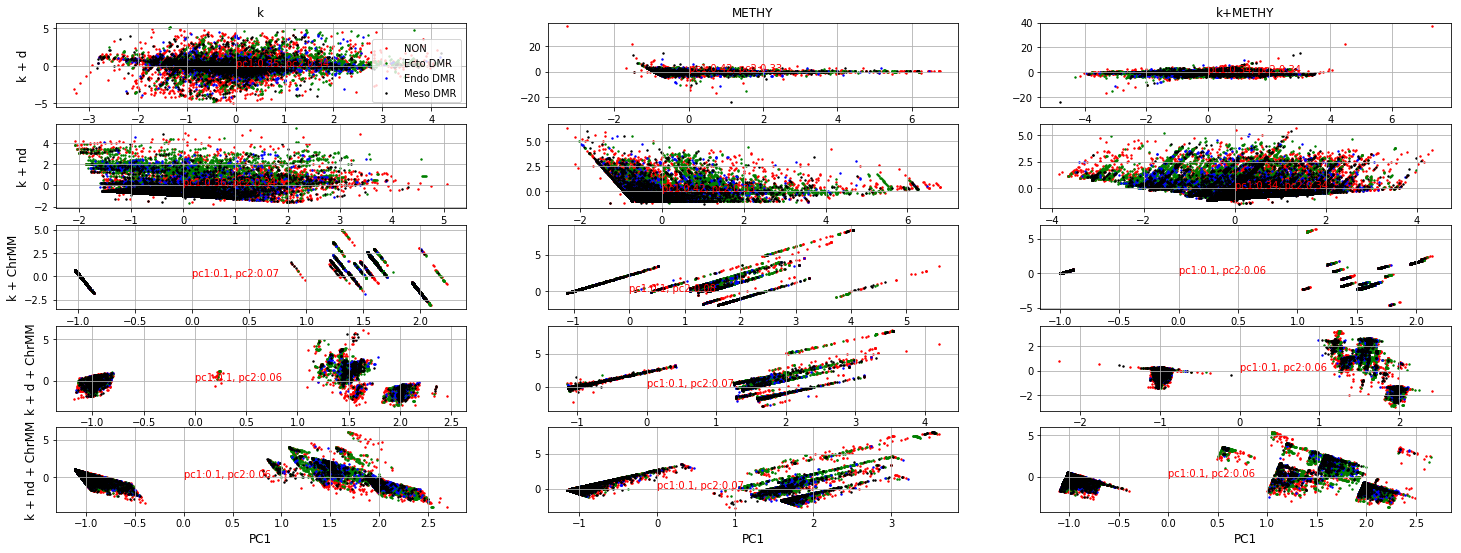

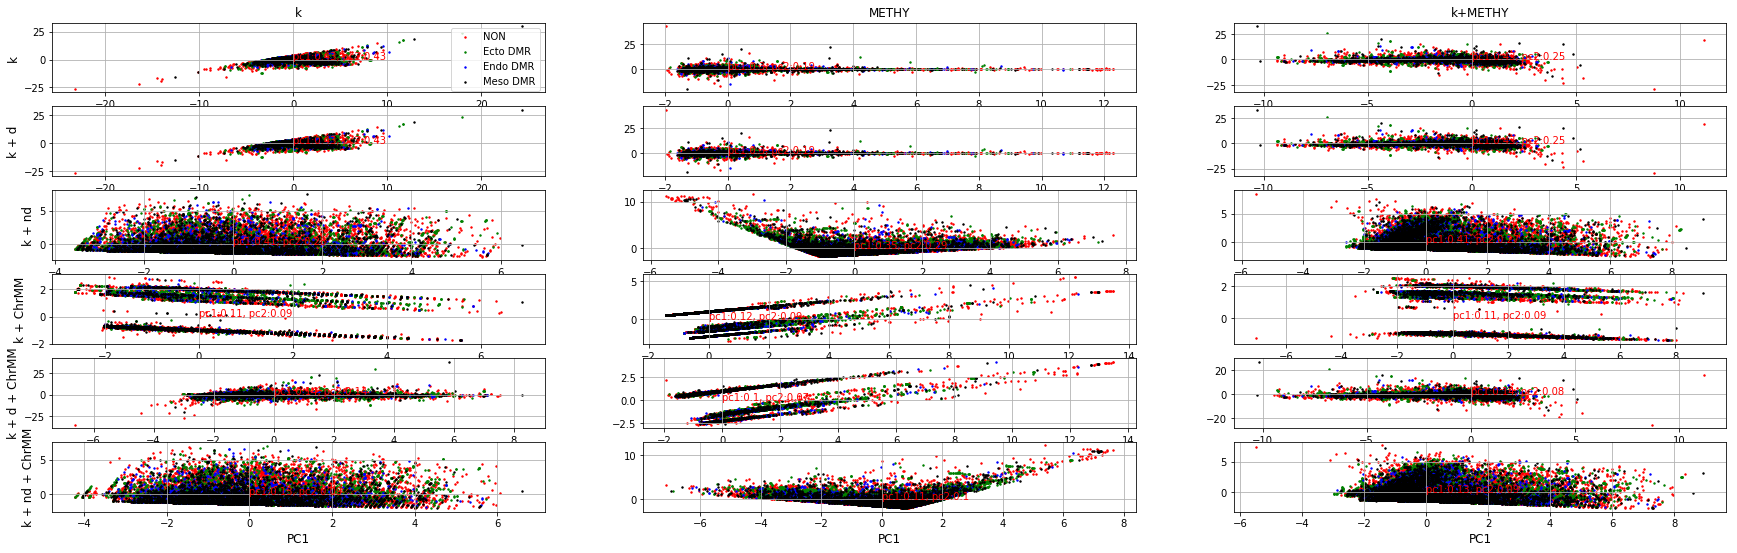

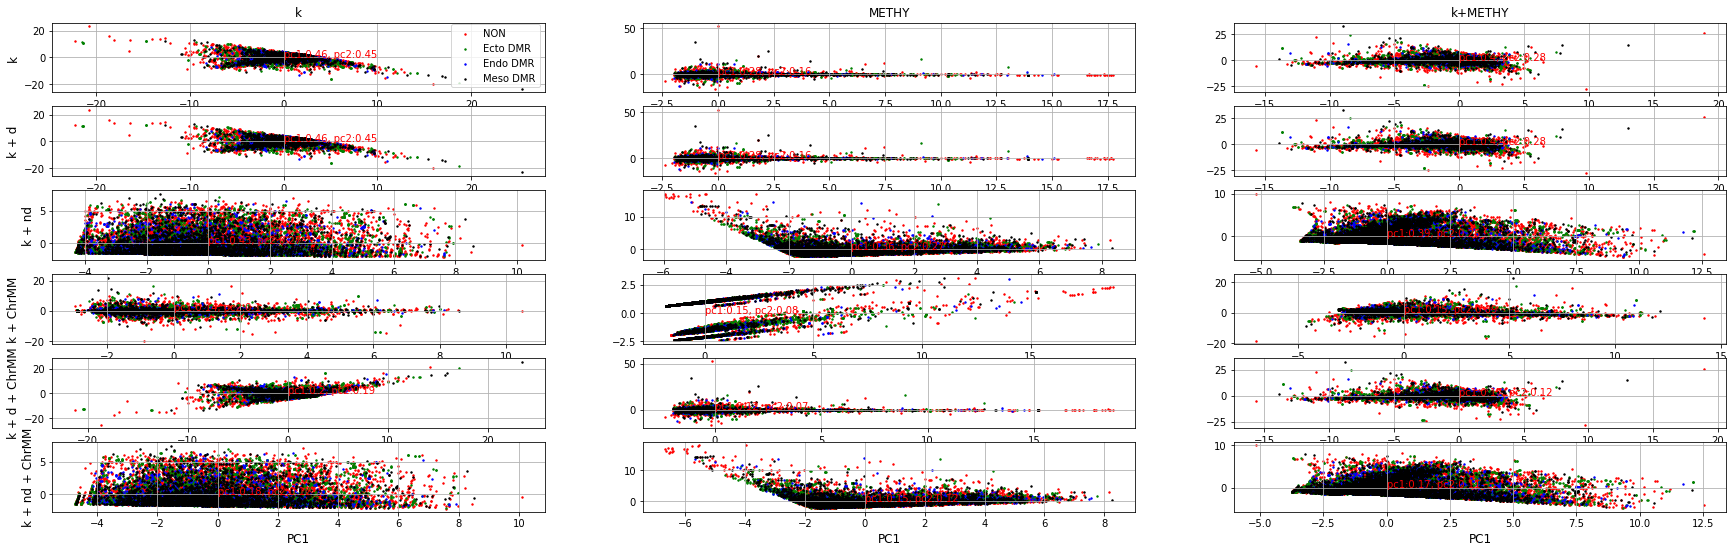

t-SNE in 30.39 seconds
t-SNE in 30.74 seconds
t-SNE in 72.25 seconds
t-SNE in 30.38 seconds
t-SNE in 31.44 seconds
t-SNE in 71.47 seconds
t-SNE in 31.02 seconds
t-SNE in 39.12 seconds
t-SNE in 92.30 seconds
t-SNE in 32.20 seconds
t-SNE in 32.36 seconds
t-SNE in 82.24 seconds
t-SNE in 30.53 seconds
t-SNE in 34.11 seconds
t-SNE in 76.96 seconds


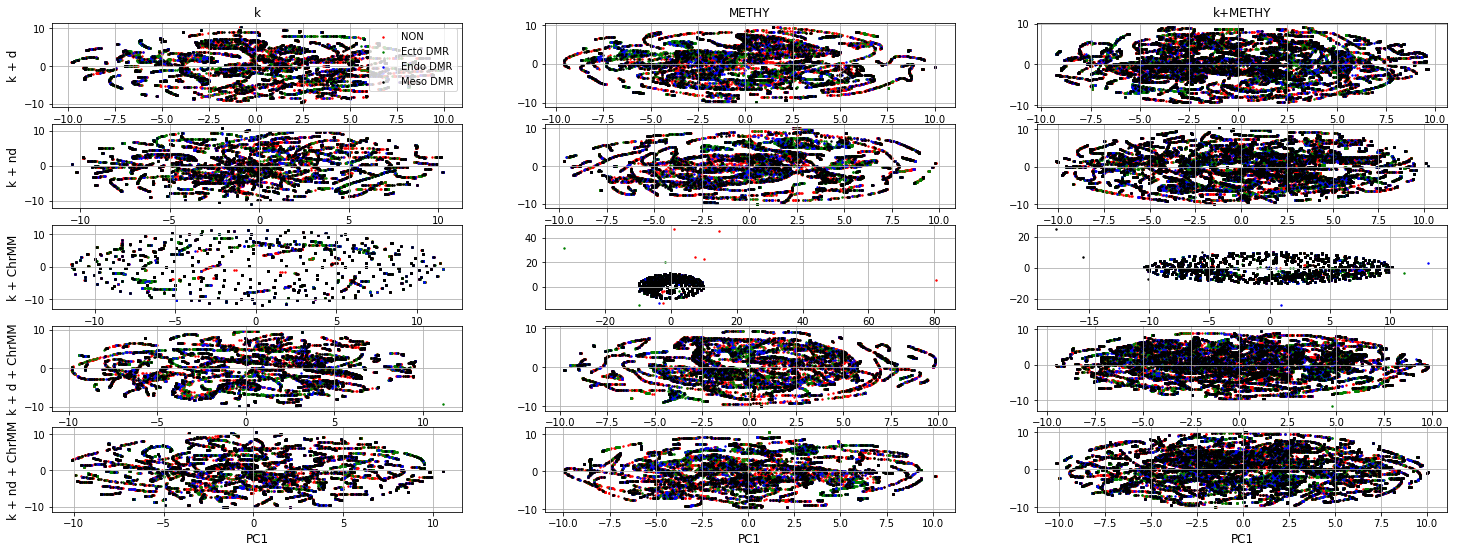

t-SNE in 30.59 seconds
t-SNE in 33.66 seconds
t-SNE in 74.89 seconds
t-SNE in 31.26 seconds
t-SNE in 35.78 seconds
t-SNE in 74.25 seconds
t-SNE in 31.01 seconds
t-SNE in 37.19 seconds
t-SNE in 78.47 seconds
t-SNE in 32.33 seconds
t-SNE in 34.21 seconds
t-SNE in 76.20 seconds
t-SNE in 32.79 seconds
t-SNE in 36.46 seconds
t-SNE in 77.85 seconds
t-SNE in 31.58 seconds
t-SNE in 39.67 seconds
t-SNE in 81.47 seconds


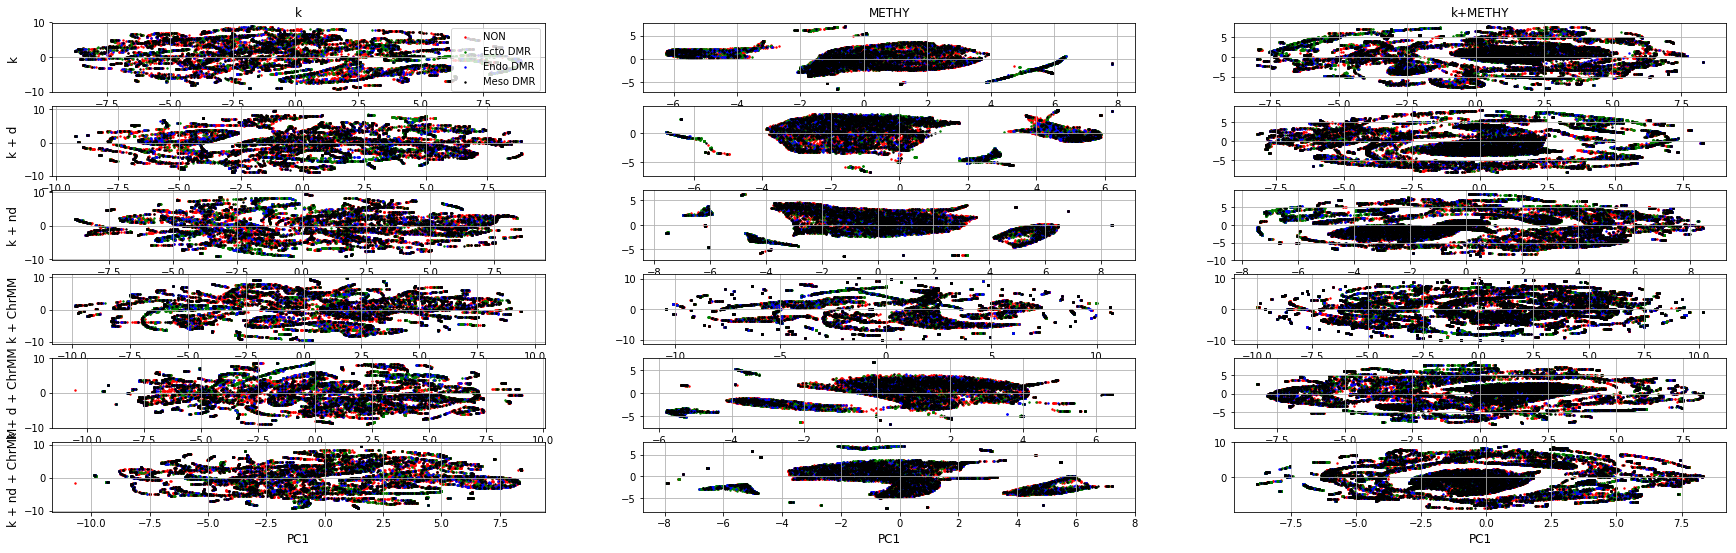

t-SNE in 44.73 seconds
t-SNE in 41.21 seconds
t-SNE in 86.22 seconds
t-SNE in 37.95 seconds
t-SNE in 34.73 seconds
t-SNE in 79.11 seconds
t-SNE in 40.92 seconds
t-SNE in 37.21 seconds
t-SNE in 77.42 seconds
t-SNE in 36.18 seconds
t-SNE in 35.98 seconds
t-SNE in 76.11 seconds
t-SNE in 38.20 seconds
t-SNE in 46.24 seconds
t-SNE in 91.77 seconds
t-SNE in 47.97 seconds
t-SNE in 45.41 seconds
t-SNE in 104.93 seconds


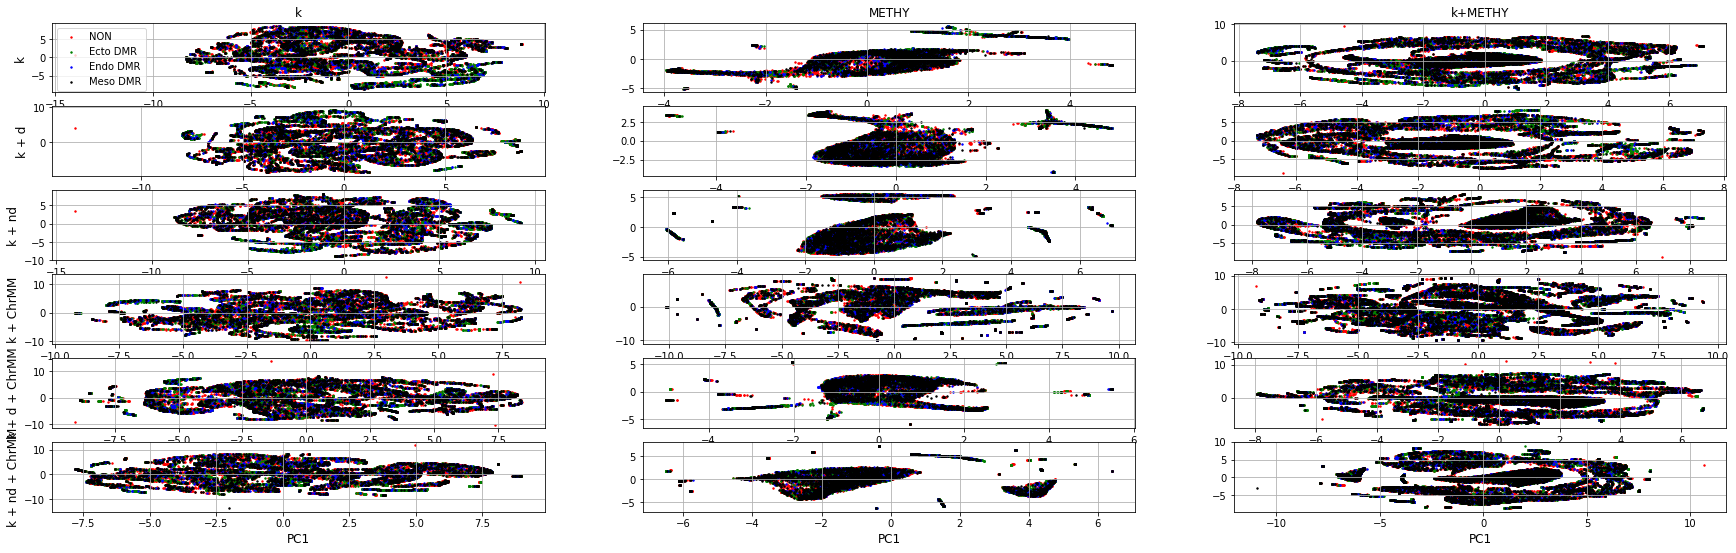

In [191]:
plot_figures()

In [3]:
def build_classifiers():
    classifier_names = [
        "LR",
        #"KNN",
        #"MLP",
        #"GBDT"
    ]

    classifiers = [
        LogisticRegression(C=1, penalty='l1', max_iter=10000),
        # KNeighborsClassifier(n_neighbors=1)#,
        #MLPClassifier(alpha=1e-5, hidden_layer_sizes=(100, 100, 20), random_state=RANDOM_STATE, max_iter=50000, learning_rate='adaptive')
        #GradientBoostingClassifier(n_estimators=5, learning_rate=.1, max_features=2, max_depth=2,random_state=RANDOM_STATE)
    ]
    return [classifier_names, classifiers]

In [4]:
[classifier_names, classifiers] = build_classifiers()

In [5]:
def prediction(klen, predict_type, X_train, X_test, Y_train,Y_test):
    performances = []
    for cidx, clf_name in enumerate(classifier_names):
        clf = classifiers[cidx].fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(X_test)
        else:
            Z = clf.predict_proba(X_test)[:, 1]
        fpr_gb, tpr_gb, _ = roc_curve(Y_test, Z)
        roc = auc(fpr_gb, tpr_gb)
        perf = [accuracy_score(Y_test, y_pred),
                       recall_score(Y_test, y_pred),
                       precision_score(Y_test, y_pred),
                       f1_score(Y_test, y_pred),
                       roc]
        print("%s\t%s\t%s\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (str(klen), predict_type,
                                                            clf_name, accuracy_score(Y_test, y_pred),
                                                            recall_score(Y_test, y_pred),
                                                            precision_score(Y_test, y_pred),
                                                            f1_score(Y_test, y_pred),
                                                            roc))
        performances.append(perf)
    return performances

In [6]:
def machine_learning(DATA_DIR, klen):
    FIELD_ARR_HERE = FIELD_ARR[1 : ] if klen == 1 else FIELD_ARR
    FIELD_LABELS_HERE = FIELD_LABELS[1 : ] if klen == 1 else FIELD_LABELS
    performances = [[] for item in range(len(FIELD_ARR_HERE))]

    for f_i, filed in enumerate(FIELD_ARR_HERE):
        for d_i, type_name in enumerate(DATA_TYPE_ARR):
            if K_KEY == type_name:
                data_type = 'MIN'
                x_train, x_test, y_train, y_test = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
            elif METHY_KEY == type_name:
                data_type = METHY_KEY
                x_train, x_test, y_train, y_test= obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
            elif K_METHY_KEY == type_name:
                data_type = 'MIN'
                x_train1, x_test1, y_train1, y_test1 = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
                data_type = METHY_KEY
                x_train2, x_test2, y_train2, y_test2 = obtain_data_by_field_selection(DATA_DIR, klen, data_type, filed)
                x_train = np.concatenate((x_train1, x_train2), axis=0)
                y_train = np.concatenate((y_train1, y_train2), axis=0)
                x_test = np.concatenate((x_test1, x_test2), axis=0)
                y_test = np.concatenate((y_test1, y_test2), axis=0)
            else:
                return
            y_train[y_train > 0] = 1
            y_test[y_test > 0] = 1
            predict_type = FIELD_LABELS_HERE[f_i] + " " + type_name
            perf = prediction(klen, predict_type, x_train, x_test, y_train, y_test)
            performances[f_i].append(perf)
    return performances

In [7]:
OUT_DIR = '../DATA/MINI_DATA_SET'

In [12]:
performances = machine_learning(OUT_DIR, 3)

/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k k	LR	0.55	0.38	0.58	0.46	0.58
3	k METHY	LR	0.57	0.41	0.60	0.49	0.60


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k k+METHY	LR	0.56	0.40	0.58	0.47	0.59
3	k + d k	LR	0.55	0.38	0.58	0.46	0.58


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + d METHY	LR	0.57	0.41	0.60	0.49	0.60


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + d k+METHY	LR	0.56	0.40	0.58	0.47	0.59


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + nd k	LR	0.55	0.37	0.58	0.46	0.58


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + nd METHY	LR	0.57	0.42	0.60	0.49	0.60


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + nd k+METHY	LR	0.56	0.39	0.58	0.47	0.59
3	k + ChrMM k	LR	0.58	0.24	0.77	0.36	0.62


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + ChrMM METHY	LR	0.59	0.32	0.70	0.44	0.64


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + ChrMM k+METHY	LR	0.58	0.26	0.73	0.39	0.62


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + d + ChrMM k	LR	0.58	0.24	0.77	0.36	0.62


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + d + ChrMM METHY	LR	0.59	0.32	0.70	0.44	0.64


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + d + ChrMM k+METHY	LR	0.58	0.27	0.73	0.39	0.62
3	k + nd + ChrMM k	LR	0.58	0.24	0.77	0.36	0.62


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + nd + ChrMM METHY	LR	0.60	0.34	0.69	0.46	0.64


/Users/emmanueldollinger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3	k + nd + ChrMM k+METHY	LR	0.58	0.27	0.73	0.40	0.63


In [14]:
performances =np.array(performances)

In [15]:
print(performances.shape)

(6, 3, 1, 5)


In [19]:
def generate_table(out_dir, klen, performances):
    FIELD_LABELS_HERE = FIELD_LABELS[1:] if klen == 1 else FIELD_LABELS
    performances = np.array(performances)
    metrics = ['accuarcy', 'recall', 'precision', 'f1', 'roc']
    for c_i, classifier_name in enumerate(classifier_names):
        for m_i, metric in enumerate(metrics):
            out_fp = os.path.join(out_dir, str(klen) + '_' + classifier_name+ "_" + metric + ".csv")
            performance = performances[:,:, c_i, m_i]
            row_names = np.array(FIELD_LABELS_HERE).reshape((performance.shape[0]), 1)
            performance = np.concatenate((row_names, performance), axis=1)
            print(performance)
            np.savetxt(out_fp, performance[:, :], fmt="%s,%.2f,%.2f,%.2f", delimiter='\n', header= ',' + ','.join(DATA_TYPE_ARR))

In [20]:
PERF_DIR='../DATA/ML_PERFORMANCE'
generate_table(PERF_DIR, 3, performances)

[['k' '0.5545742753623188' '0.5685009057971014' '0.5559895833333334']
 ['k + d' '0.5545742753623188' '0.5686141304347826' '0.556046195652174']
 ['k + nd' '0.5532155797101449' '0.5703125' '0.555083786231884']
 ['k + ChrMM' '0.5828804347826086' '0.5912590579710145'
  '0.5839560688405797']
 ['k + d + ChrMM' '0.5828804347826086' '0.5921648550724637'
  '0.5840126811594203']
 ['k + nd + ChrMM' '0.5829936594202898' '0.5955615942028986'
  '0.5849184782608695']]


TypeError: Mismatch between array dtype ('<U32') and format specifier ('%s,%.2f,%.2f,%.2f')